# Day 9 - Hexagons

Hexgrid of London made with [h3 python library](https://github.com/uber/h3).

Data from Department for Transport - Road Safety Statistics (stats19). Download [here](https://www.gov.uk/government/collections/road-accidents-and-safety-statistics).

## Setup

In [1]:
import os
import configparser

import geopandas as gpd
import h3
from shapely.geometry import Point, Polygon
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize

In [2]:
#set filepaths
project_root = os.path.abspath(os.getcwd())
root = os.path.abspath(os.path.join(os.getcwd(), '..', '..'))
config_file =  os.path.join(root, 'config.cfg')

# geodata for shapefiles
config = configparser.ConfigParser()
config.read(config_file)
gdata_root = config['geodata']['path']

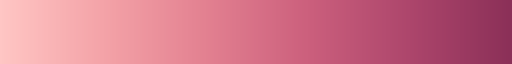

In [3]:
# import colors
import matplotlib.colors as colors
from palettable.cmocean.sequential import Matter_10
from palettable.cartocolors.sequential import BrwnYl_7, Burg_7, BurgYl_7, Magenta_7
cmap = colors.LinearSegmentedColormap.from_list('cmap',[colors.hex2color(c) for c in  Matter_10.hex_colors[0:-3]])
cmap = colors.LinearSegmentedColormap.from_list('cmap',[colors.hex2color(c) for c in  Burg_7.hex_colors[0:-1]])
cmap

In [4]:
# set custom fonts
plt.rcParams['font.family'] = ['Inter']
from matplotlib import font_manager
subtitle_font = font_manager.FontProperties(fname='C:\\Windows\\Fonts\\Inconsolata-Medium.ttf')
title_font = font_manager.FontProperties(fname='C:\\Windows\\Fonts\\Inconsolata-Semibold.ttf')

## Load data

### Load shapefiles

In [5]:
# read London shapefile and reproject to coordinate system to match grid
london_all = gpd.read_file(os.path.join(gdata_root, 'london-shapefiles\\london-no-river.geojson'))

# load river shapefile
river = gpd.GeoDataFrame.from_file(os.path.join(gdata_root, 'london-shapefiles\\river-thames-clipped.geojson'))

### Load accident data

In [6]:
# dictionary to map codes to labels
labels =  pd.read_excel("dft-road-casualty-statistics-road-safety-open-dataset-data-guide-2022.xlsx")

In [7]:
# load data sets
data = {"vehicle":[], "casualty":[],  "collision":[]}

for dataset in data.keys():
    files = []
    files.append( "dft-road-casualty-statistics-%s-2022.csv"%(dataset)) 
    for filename in files:
        df = pd.read_csv(filename, low_memory=False)
        data[dataset].append(df)
    data[dataset] = pd.concat(data[dataset], axis=0, ignore_index=True)
    data[dataset]["accident_index"] = data[dataset]["accident_index"].astype(str)

## Process data

### get hexagons for London

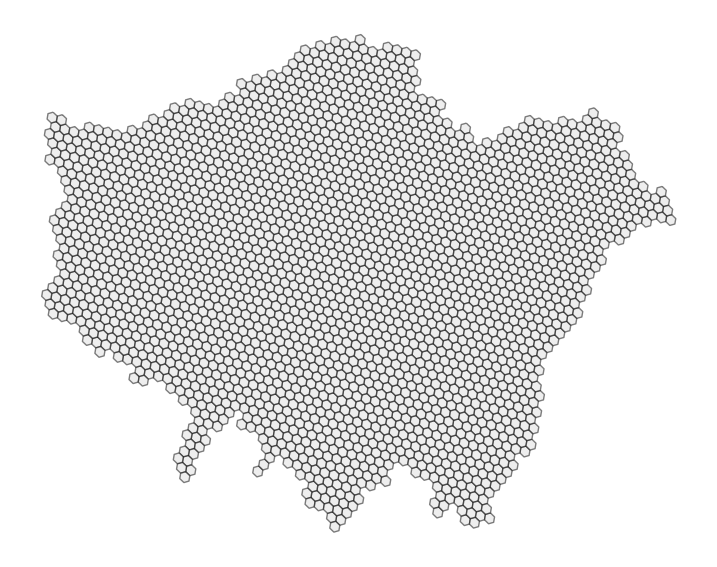

In [8]:
#Get all polygons that intersect our area of interest
hexs = h3.polyfill(london_all["geometry"].iloc[0].__geo_interface__, 8, geo_json_conformant = True)

#Set up a simple lambda function that makes the geo_boundary call from a hex id
polygonise = lambda hex_id: Polygon(h3.h3_to_geo_boundary(hex_id, geo_json=True))

#Create a geodataframe and populate the geometrie field with the result of the polygonise function with the hexs variable for input
all_polys = gpd.GeoSeries(list(map(polygonise, hexs)), index=hexs, crs="EPSG:4326")

#Plot to see how it looks
ax = all_polys.plot(alpha=0.5, color="#DEDEDE", edgecolor="black", figsize=(9, 9))
ax.axis("off")
plt.show()

In [9]:
# convert to geodataframe to join with points data later
gdf_poly = gpd.GeoDataFrame(crs = 'EPSG:4326', geometry=all_polys)
gdf_poly = gdf_poly.reset_index().rename(columns={"index": "name"})
gdf_poly.head()

,name,geometry
0,88194ad921fffff,"POLYGON ((-0.39082 51.46519, -0.39754 51.46398..."
1,88194ac263fffff,"POLYGON ((-0.08909 51.37871, -0.09578 51.37751..."
2,88194ac04bfffff,"POLYGON ((-0.10434 51.34615, -0.11103 51.34495..."
3,88194e6dc3fffff,"POLYGON ((0.13912 51.44476, 0.13242 51.44358, ..."
4,88194ac039fffff,"POLYGON ((-0.13173 51.31566, -0.13841 51.31446..."


In [10]:
# get outline for plot
gdf_poly_outline  = gpd.GeoDataFrame({'name': ['london'], 'geometry': gdf_poly.to_crs(4326).unary_union}, crs="EPSG:4326")

In [11]:
# save as geojson to reuse in future projects
gdf_poly.to_file(os.path.join(gdata_root, "hexgrids\\london-h3-level8.geojson"))

### Prepare accident data

In [12]:
# group vehicle types
classes = {0: "Pedestrian", 1 : "Pedal cycle", 2: "Motorbike", 3: "Motorbike", 4: "Motorbike", 5: "Motorbike", 
                 97: "Motorbike", 8: "Car",  9: "Car", 10: "Bus", 11: "Bus", 16: "Other", 17: "Other", 18: "Tram",
                19: "Van", 20: "Heavy", 21: "Heavy", 22: "Scooter", 23: "Electric motorcycle", 90: "Other",
                98: "Heavy", 99: "Other" }

# relevant columns from collision
coll_cols = ['accident_index', 'accident_year', 'longitude', 'latitude', 'accident_severity', 'number_of_vehicles',
            'number_of_casualties', 'date', 'day_of_week', 'time','local_authority_ons_district', 'first_road_class', 
            'road_type','speed_limit', 'junction_detail',]

In [13]:
# reduce dataframe to relevant columns
df = data["collision"][coll_cols]

# match codes against labels
for column in ["accident_severity", "day_of_week", 'first_road_class', 'road_type', 'junction_detail',]:
    _filter = labels["field name"]==column
    df.loc[:, column] = df.loc[:, column].map(dict(zip(labels[_filter]["code/format"], labels[_filter]["label"])))

In [14]:
# merge with vehicles
data["vehicle"]["vehicle_group"] = data["vehicle"]["vehicle_type"].map(classes)
veh_involved = data["vehicle"].groupby(["accident_index",
                                 "vehicle_group"])["accident_index"].count().unstack().reset_index().fillna(0)
df = pd.merge(df, veh_involved, left_on="accident_index", right_on="accident_index", how="left")

# merge with casualties
data["casualty"]["casualty_group"] = data["casualty"]["casualty_type"].map(classes)
cas_caused = data["casualty"].groupby(["accident_index",
                                 "casualty_group"])["accident_index"].count().unstack().fillna(0)
cas_caused = cas_caused.add_prefix('Cas_').reset_index()
df = pd.merge(df, cas_caused, left_on="accident_index", right_on="accident_index", how="left")

# convert to geo dataframe
geometry = [Point(xy) for xy in zip(df['longitude'].astype(float), df['latitude'].astype(float))]
gdf = gpd.GeoDataFrame(df, crs = 'EPSG:4326', geometry = geometry)

### More processing

In [15]:
# filter for cycle accidents
_filter = gdf["Pedal cycle"]>0
gdf_filtered = gdf[_filter].reset_index(drop=True)

#  #merge data to hexgrid
merged = gpd.sjoin(gdf_filtered, gdf_poly, how='left')

# make a count variable that we can sum per grid cell
merged['collisions']=1
dissolve = merged.dissolve(by='index_right', aggfunc='count')

# include count in hexgrid
gdf_poly.loc[dissolve.index, 'collisions'] = dissolve['collisions'].values

## Visualise

In [16]:
# dictionary of places to map
places = { 'Shoreditch': [51.522958723664935, -0.07766412768674981],
             'Camden': [51.53955149862139, -0.14262241669039177],
             'Soho': [51.51309688360682, -0.13491248421579607],
             'Hammersmith': [51.49223618549943, -0.22361215911733306],
             'Clapham':[51.46175333629983, -0.13824969876097923],
             'Camberwell': [51.474130682653644, -0.09310103554433165],
             'Dalston':[51.548199640025466, -0.0754982857534403],
             'Tooting':[51.427777560713466, -0.16763313756420725],
             'Holloway':[51.552883212571786, -0.11286608071955605],
             "Elephant & Castle": [51.49469468571915, -0.10030285876338756],
             "Vauxhall":[51.48618195698862, -0.12316154264544815]
         }
places = pd.DataFrame.from_dict(places, orient='index', columns=['lat', 'lon'])
geometry = [Point(xy) for xy in zip(places['lon'].astype(float), places['lat'].astype(float))]
places = gpd.GeoDataFrame(places, crs = '4326', geometry = geometry)

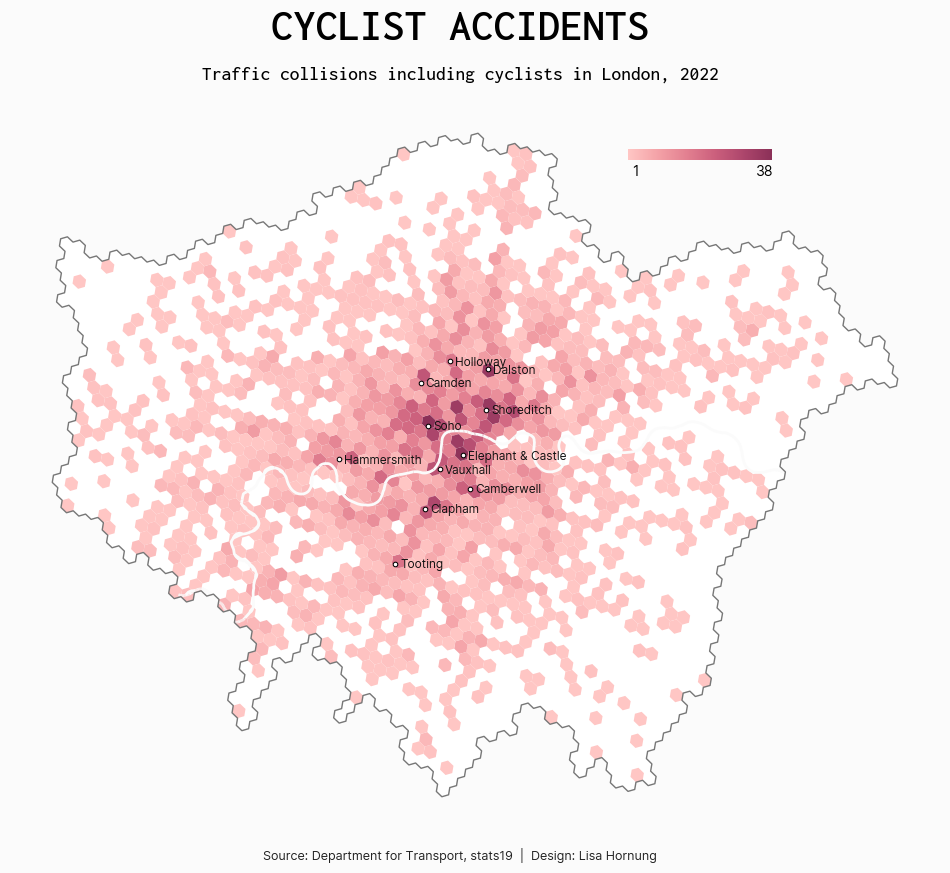

In [17]:
bg = '#FBFBFB'

# setup figure  ---------------------------
fig, ax = plt.subplots(figsize=(12, 10))
ax.axis("off")
fig.set_facecolor(bg)

# plot data  ---------------------------
gdf_poly.plot(ax=ax, column="collisions", alpha=1, zorder=2, cmap=cmap)
gdf_poly_outline.plot(ax=ax, alpha=1, zorder=1, color="#FFFFFF", linewidth=0)
gdf_poly_outline.plot(ax=ax, alpha=1, zorder=3, color="None", edgecolor="#777777",linewidth=1)

# add place names and river for reference  ---------------------------
river.plot(ax=ax, color='#FBFBFB', edgecolor='#FBFBFB', linewidth=2)
places.plot(ax=ax, markersize=11,zorder=2, color='white', edgecolor='black', linewidth=0.75)
for i in range(len(places)):
    ax.text(places['geometry'].iloc[i].x+0.005, places['geometry'].iloc[i].y, places.index[i],
            va='center_baseline', ha='left', fontsize=8.5, color='#111111')

# colorbar ---------------------------
cbaxes = fig.add_axes([0.64, 0.8, 0.12, 0.011]) #axes to hold colorbar
cmappable = ScalarMappable(norm=Normalize(0,1), cmap=cmap)              
cb = plt.colorbar(cmappable, cax=cbaxes, anchor=(1,1.2), orientation='horizontal', 
                  drawedges=False,ticks=[0.05,0.95])
cb.set_ticklabels([int(gdf_poly["collisions"].min()),int(gdf_poly["collisions"].max())])
cb.outline.set_visible(False)
cbaxes.tick_params(size=0, labelsize=10)

# title and footer  ---------------------------
plt.figtext(0.5, 0.92 , 'Cyclist accidents'.upper(), fontproperties=title_font, fontsize=32,  ha='center')
plt.figtext(0.5, 0.88 , 'Traffic collisions including cyclists in London, 2022', fontproperties=subtitle_font, fontsize=14,  ha='center')
plt.figtext(0.5, 0.1, 'Source: Department for Transport, stats19  |  Design: Lisa Hornung', fontsize=9, ha='center', color='#222222')

#save ----------------------
plt.savefig('london-cyclist-collisions.png', bbox_inches='tight', pad_inches=1, facecolor=bg, dpi=120)

plt.show()

## One time processing

Convert multipolygon to polygon first so it works in h3. Code from [this post](https://staedi.github.io/posts/multipolygon)

In [18]:
import json
filename = os.path.join(gdata_root, 'london-shapefiles\\london-no-river.geojson')
target_len = 15
 
js = open(filename, 'r').read()
gj = json.loads(js)
output = {"type":"FeatureCollection","features":[]}
 
def process_geojson(filename):
    js = open(filename, 'r').read()
    gj = json.loads(js)
    output = {"type":"FeatureCollection","features":[]}
 
    for feature in gj['features']:
        if feature['geometry'] is not None:
            if feature['geometry']['type'] == 'MultiPolygon':
                len_list = sorted([[idx, len(elem[0])] for idx, elem in enumerate(feature['geometry']['coordinates'])],key=lambda x: x[1],reverse=True)[:target_len]
                reg_len = [i[0] for i in len_list]
 
                for idx, poly in enumerate(feature['geometry']['coordinates']):
                    if len(feature['geometry']['coordinates'])<target_len or idx in reg_len:
                        xfeature = {"type":"Feature", "properties":feature["properties"], "geometry":{"type":"Polygon"}}
                        xfeature['geometry']['coordinates'] = poly
                        output['features'].append(xfeature)
            else:
                for idx, poly in enumerate(feature['geometry']['coordinates']):
                    xfeature = {"type":"Feature", "properties":feature["properties"], "geometry":feature["geometry"]}
                    output['features'].append(xfeature)
 
    open(filename, 'w').write(json.dumps(output,separators=(',',':'),ensure_ascii=False).replace('}},','}},\n'))
 
process_geojson(filename)